In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns

In [2]:
df = pd.read_csv("Data/data_daily/dataset_daily.csv", index_col='Date')
labels = df.columns.values
#eliminate observation with values equal to 0 since we have to compute log ret
df = df[(df==0.0).sum(axis=1) ==0]

In [3]:
#compute returns
#ret = df.diff() / df.shift(1)
nfeature = len(df.columns)
ret = np.log(df /df.shift())

#drop nan
ret = ret.loc[ret.isnull().sum(axis=1) == 0]

#compute mean std
means = ret.mean()
stds = ret.std()

#normlize
ret = (ret-ret.mean())/ret.std()

labels = ret.columns.values

In [4]:
ret

,Open_USD_CHF,Open_CHF_EUR,Open_CHF_GBP,Open_CHF_JPY,Open_CHF_CAD,Open_BondCH1m,Open_BondCH2y,Open_BondCH10y,Open_SMI,Open_USD_JPY,Open_USD_EUR,Open_USD_GBP,Open_USD_CAD,Open_BondUS1m,Open_BondUS2y,Open_BondUS10y,Open_SP500
Date,,,,,,,,,,,,,,,,,
2001-12-28,-0.822907,0.595643,1.128423,1.610098,0.523328,-0.007683,0.067921,0.028324,0.452954,0.936942,-0.466862,0.243397,-0.285110,-0.052121,-0.910228,0.390010,0.537281
2002-01-04,-2.085487,-0.364807,3.361038,2.041981,1.948052,0.003090,-0.113503,-0.087894,-0.263222,0.056312,-2.513711,1.469186,0.036702,0.008048,-0.004974,0.124963,0.976228
2002-01-07,0.139153,0.735510,-1.003688,-0.846045,-0.271038,-0.051160,0.663134,-0.009985,-0.016085,-0.866571,0.565977,-1.050630,-0.275504,-0.042663,-0.789350,-0.677789,0.241288
2002-01-08,-0.287198,0.676396,0.904953,0.343327,0.451094,-0.063536,-0.016072,-0.042798,-0.637879,0.164156,0.262208,0.754869,0.318710,-0.034653,0.113616,0.327792,-0.669751
2002-01-09,0.604588,-0.728370,-0.420685,1.042419,-0.732027,-0.065310,-0.006884,-0.010203,-0.381083,1.840677,0.078155,0.152247,-0.214989,-0.019397,-0.635050,-0.304811,-0.116231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-15,0.297370,-0.667586,-0.335363,-0.873914,-0.286446,-0.087480,0.053183,-0.210699,-0.192845,-0.628193,-0.086322,0.035975,0.055097,-0.000362,-0.378321,-1.826462,-0.671612
2017-06-16,0.644571,0.429564,-0.690145,0.992906,-0.322427,0.052492,-0.048774,-0.089104,0.412983,1.752150,0.965183,-0.101881,0.309849,-0.124937,0.397569,0.925076,0.229414
2017-06-19,-0.278899,-0.668215,-0.202198,0.059425,-0.314306,-0.067857,0.021308,-0.466371,0.937086,-0.100888,-0.693176,-0.397934,-0.625080,-0.095708,-0.651216,-0.177200,0.370257


In [5]:
train_data_length = len(ret)
train_data = torch.zeros((train_data_length, nfeature))
train_labels = torch.zeros(train_data_length)

for i, col in enumerate(labels):
    train_data[:, i] = torch.tensor(ret[col].iloc[:train_data_length].values)

train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

batch_size = 50
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
        nn.Linear(nfeature, 256),
        nn.LeakyReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.LeakyReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 1),
        nn.Sigmoid(),)
            
    def forward(self, x):
        output = self.model(x)
        return output
    
discriminator = Discriminator()

In [7]:
def addnoise(samples):
    n, d = samples.shape
    noise = np.random.uniform(low = -0.1, high = 0.1, size = (n,1))
    return samples + torch.Tensor(noise)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nfeature, 100),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(100, 300),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(300,100),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(100, nfeature),)

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [9]:
lr = 0.001
num_epochs = 200
loss_function = nn.BCELoss()

In [10]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr*0.7)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
    
        latent_space_samples = torch.randn((batch_size, nfeature))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        #print(f'real: {real_samples.shape}, gen: {generated_samples.shape}')
        all_samples = torch.cat((real_samples, generated_samples))
        
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        all_samples_labels = addnoise(all_samples_labels)

        # Training the discriminator
        discriminator.zero_grad()
        #print(all_samples.shape)
        output_discriminator = discriminator(all_samples)
        #print(output_discriminator.shape, all_samples_labels.shape )
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, nfeature))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        #print(generated_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6620924472808838
Epoch: 0 Loss G.: 0.7611950635910034
Epoch: 10 Loss D.: 0.5862389206886292
Epoch: 10 Loss G.: 2.2488927841186523
Epoch: 20 Loss D.: 0.5725794434547424
Epoch: 20 Loss G.: 0.6987698078155518
Epoch: 30 Loss D.: 0.4573131799697876
Epoch: 30 Loss G.: 0.8145301938056946
Epoch: 40 Loss D.: 0.7398422360420227
Epoch: 40 Loss G.: 1.0632129907608032
Epoch: 50 Loss D.: 0.6114791035652161
Epoch: 50 Loss G.: 0.8999931812286377
Epoch: 60 Loss D.: 0.4723358452320099
Epoch: 60 Loss G.: 1.1230902671813965
Epoch: 70 Loss D.: 0.7193319201469421
Epoch: 70 Loss G.: 0.745940089225769
Epoch: 80 Loss D.: 0.7561174035072327
Epoch: 80 Loss G.: 0.6318784356117249
Epoch: 90 Loss D.: 0.7180996537208557
Epoch: 90 Loss G.: 0.684776246547699
Epoch: 100 Loss D.: 0.6600837111473083
Epoch: 100 Loss G.: 0.7280684113502502
Epoch: 110 Loss D.: 0.9003703594207764
Epoch: 110 Loss G.: 0.5932015776634216
Epoch: 120 Loss D.: 0.9644458293914795
Epoch: 120 Loss G.: 0.6825412511825562
Epoch: 130

In [12]:
lag_num = 6
sim = 1000
generated = torch.zeros((lag_num, nfeature, sim))

for i in range(sim):
    latent_space_samples = torch.randn((lag_num, nfeature))
    generated[:,:,i] = generator(latent_space_samples)

In [13]:
labels

array(['Open_USD_CHF', 'Open_CHF_EUR', 'Open_CHF_GBP', 'Open_CHF_JPY',
       'Open_CHF_CAD', 'Open_BondCH1m', 'Open_BondCH2y', 'Open_BondCH10y',
       'Open_SMI', 'Open_USD_JPY', 'Open_USD_EUR', 'Open_USD_GBP',
       'Open_USD_CAD', 'Open_BondUS1m', 'Open_BondUS2y', 'Open_BondUS10y',
       'Open_SP500'], dtype=object)

In [14]:
#Compute the marginal distributions for generated and real data
labels_real = []
[labels_real.append(i + '_real') for i in labels]
labels_gen = []
[labels_gen.append(i + '_gen') for i in labels]
#trasfrom the tensors in DataFrames
real_ret = pd.DataFrame(train_data[:,:].numpy())
real_ret = (real_ret*stds.values) + means.values
real_ret.columns = labels_real

#recreate a "time series" like to chek marginal distirubuitons and copulas
generated = generated.detach()
generated_ret = pd.DataFrame(generated[:,:,0].numpy())
for i in range(sim):
    generated_ret = pd.concat([generated_ret, pd.DataFrame(generated[:,:,i].numpy())])
    
generated_ret = generated_ret.iloc[lag_num:,:]

generated_ret = generated_ret  * stds.values + means.values
generated_ret.columns = labels_gen
generated_ret = generated_ret.reset_index()
generated_ret=generated_ret.iloc[:,1:]



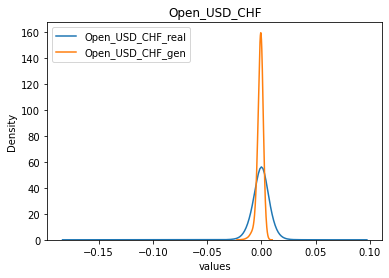

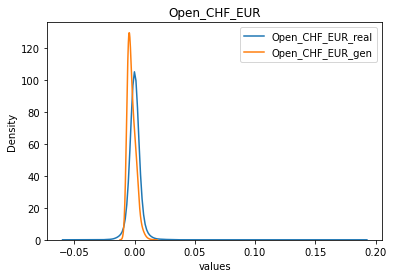

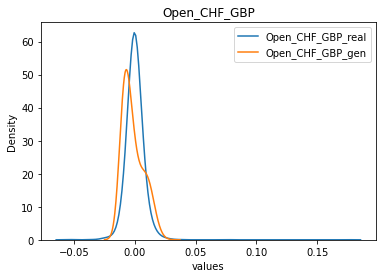

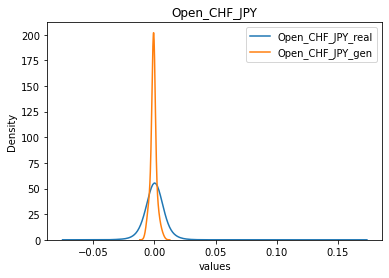

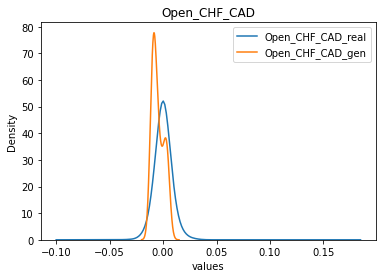

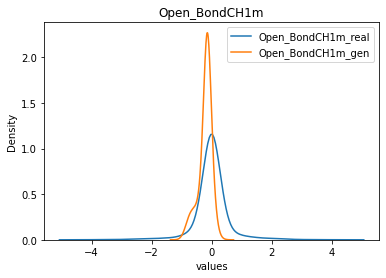

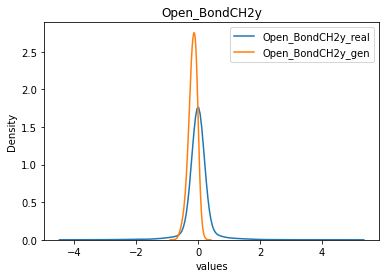

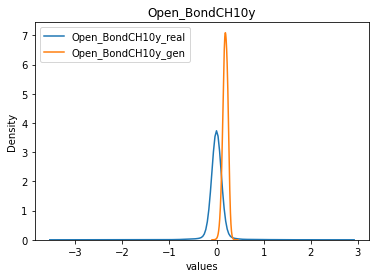

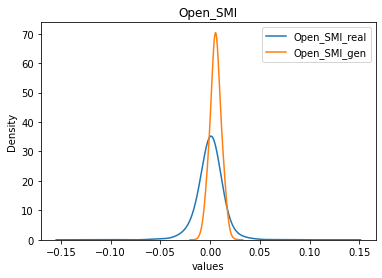

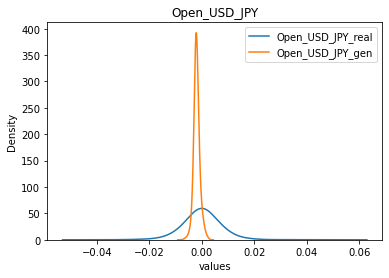

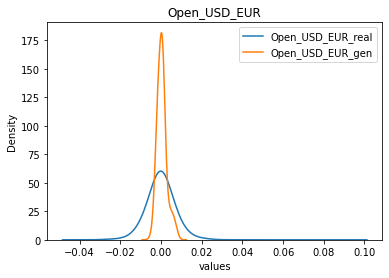

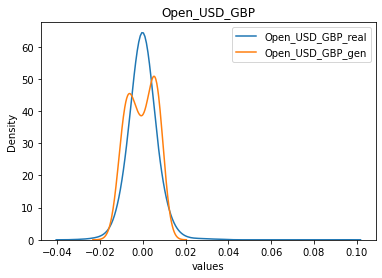

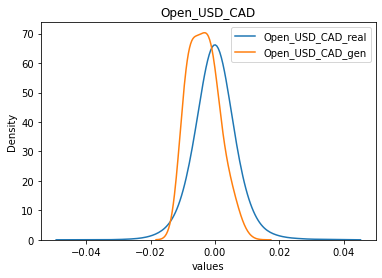

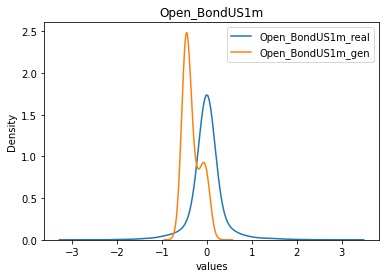

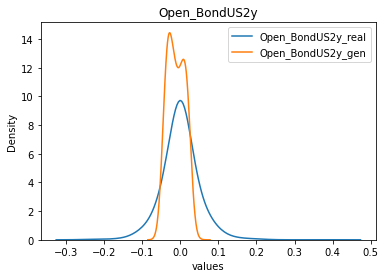

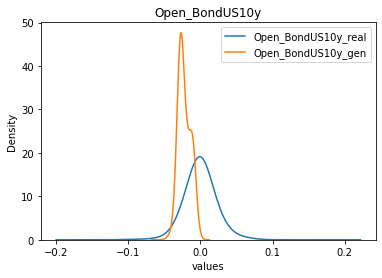

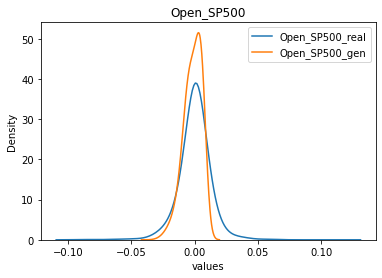

In [15]:
#plot the marginal distributions of generated scenarios against the true ones
for i, _ in enumerate(real_ret):
    #d = {f'{labels_real[i]}':real_ret.iloc[:,i],f'{labels_gen[i]}': generated_ret.iloc[:,i]}
    sns.kdeplot(real_ret.iloc[:,i], bw_method=0.5, label = f'{labels_real[i]}')
    sns.kdeplot(generated_ret.iloc[:,i],bw_method=0.5,label = f'{labels_gen[i]}')
    plt.xlabel('values')
    plt.title(f'{labels[i]}')
    plt.legend()
    #plt.savefig(fname=f'{i} marginal ',  format='pdf')
    plt.show()
    

In [16]:
#This corresponds to the map X ! FX(X), and the transformed returns are now uniformly distributed on [0, 1]
real_unif = real_ret.rank(axis=0)/len(real_ret)
real_unif.columns = labels_real

generated_unif = generated_ret.rank( axis = 0)/len(generated_ret)
generated_unif.columns = labels_gen

In [ ]:
#plot the pairwise empirical copulas and compare them with the true ones
real_unif.columns = labels
generated_unif.columns = labels

for n, i in enumerate(generated_unif.columns[:-1]):
    for j in generated_unif.columns[n+1:]:
        a = plt.scatter(real_unif[i],real_unif[j],s=3, c='red')
        b = plt.scatter(generated_unif[i],generated_unif[j],s=3)
        plt.title(f'{i},{j}')
        plt.xlabel(f'{i}')
        plt.ylabel(f'{j}')
        plt.legend((a,b),('real', 'generated'))
        #plt.savefig(fname=f'{i},{j} copulas ',  format='pdf')
        plt.show()
        